# Class 6: Word embeddings



## Preparation for class
---

So was sick friday so didn't get the chance to get this out before the weekend. So you really don't have to prepare anything, but I might be worth going through the gensim section code to get an overview before class and to make sure that everything work as intended.

## Gensim
---


You can install gensim simply using: 
```py
pip install gensim
```


### Using Gensim
to start us of we can download the word embeddings we will use for class using:

In [51]:
import gensim.downloader as api
from typing import List

# Pre-trained vectors based on Wikipedia 2014 + Gigaword, 
# 5.6B tokens, 400K vocab, 
# uncased (https://nlp.stanford.edu/projects/glove/).
# embedding size 50 (so fairly small, but easy to work with)
word_emb = api.load("glove-wiki-gigaword-300") #changed from 50

We can the parts of the word embedding class here, but I do encourage you to inspect it a bit more using e.g. `dir(word_emb)` or `help(word_emb)`:

In [2]:
print(type(word_emb))

# inspecting the vocabulary
vocab = word_emb.vocab.keys()
vocab = sorted(list(vocab)) # sort the vocab
print(vocab[:10])
print(vocab[51000: 51010])
print(vocab[-10:])

<class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>
['!', '!!', '!!!', '!!!!', '!!!!!', '!?', '!?!', '"', '#', '##']
['alemtuzumab', 'alemu', 'alemán', 'alemão', 'alen', 'alena', 'alencar', 'alencon', 'alendronate', 'alene']
['門下省', '魏博', '鳳翔', '법정동', '행정동', 'ﬁeld', 'ﬁgures', 'ﬁnds', 'ﬁrst', '￥']


We can now extract word embeddings for words in the vocabulary:

In [3]:
# fetch the word embedding for class
glass = word_emb["glass"]
print(type(glass))
print(glass.shape) # fairly small word embedding

print("aarhus" in word_emb) # check if word in vocabulary


<class 'numpy.ndarray'>
(50,)
True


As you probably know from the lectures the similarity between word embedding is calculated using cosine similarity, which you might recall we implemented in the introduction week. We can use this to calculate the similarity between a couple of vectors here:

In [4]:
import numpy as np
def cosine(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

for w1, w2 in [("dog", "dog"), ("dog", "glass"), ("dog", "cat")]:
    sim = cosine(word_emb[w1], word_emb[w2])
    print(f"the similarity between {w1} and {w2} is {round(sim, 2)}")

# You can also calculate this using gensim:
word_emb.similarity('dog', 'glass')


the similarity between dog and dog is 1.0
the similarity between dog and glass is 0.27000001072883606
the similarity between dog and cat is 0.9200000166893005


0.27108672

You could imagine doing this for all words in the corpus to get the most similar words to `dog`, using gensim this can be done simply using:

In [5]:
print(word_emb.most_similar("dog", topn=10))

[('cat', 0.9218005537986755), ('dogs', 0.8513159155845642), ('horse', 0.7907583713531494), ('puppy', 0.7754921913146973), ('pet', 0.7724707722663879), ('rabbit', 0.7720813751220703), ('pig', 0.7490061521530151), ('snake', 0.7399188280105591), ('baby', 0.7395570874214172), ('bite', 0.7387937903404236)]


This function also helps you do analogies, *"woman is to ____ what man is to king"* or rephrased *king-man + woman = ?*:

In [6]:
# you can also do analogies using this function:
sim = word_emb.most_similar(positive = ["woman", "king"], negative=["man"], topn=1)
print(sim)

[('queen', 0.8523603677749634)]


Naturally the phrase *"king - man + woman = ?"* is nonsense, you can't do mathematics with words, but you can with word embeddings. So let us just go through what is going on here:
We start of taking the word embedding of king $w_{king}$ substract the word embedding for man $w_{man}$ and then add the word embedding for women $w_{woman}$, thus we have: 

$$w_{anology} = w_{king} - w_{man} + w_{woman}$$

Naturally it would be extremely coincidental that we were to have $w_{anology}$ being equal to $w_{queen}$, what we actually do is calculate the similarity between all vectors and $w_{anology}$ and find that $w_{queen}$ is the closest to that one, thus: 

$$w_{anology} \sim w_{queen}$$

Do note that we are working with vectors and that these are [cummutative](https://en.wikipedia.org/wiki/Commutative_property) (e.g. $v_1 + v_2 = v_2 + v_1$) thus it is just as valid to write:

$$w_{anology} = w_{king} + w_{woman} - w_{man} = w_{king} + (w_{woman} - w_{man})$$

Where you can interpret $w_{woman} - w_{man}$ as the *gender component* assuming that everything else about the usage of man and woman is similar i.e. they both refer to human, typically adult and seen as a neutral gendered description of a person. Even in simple cases such as this one it is trivially not true, *man* can even refer to a member of mankind (*god cares for all men*) an authority (*the man*) or can be used as an exclamation (*oh man*). 


<details>
    <summary> That sounds like a problem, what do we do to solve it? </summary>

Glad you ask. Well there are multiple and probably more than I don't know of. One way is to concieve the other meanings as noise in the *gender component* and one way to remove it is to average over mulitple gender components (another one could be $w_{girl} - w_{boy}$), you could probably imagine others as well. Another way is to disambiguate the word embeddings (by created the word embedding for each different meaning of the word), not a trivial task, but one place where you can start is including the part-of-speech tag and thus distingushing between e.g. *desert* as verb or *desert* as a noun. Word sense disambiguation is still an active area of reasearch.


</details>

<br /> 


### Plotting word embeddings
We naturally can't plot a word embedding with an embedding size larger than three so what we can do instead is reduce the dimensionality e.g. using a PCA, which some of you might be familiar with.

<details>
    <summary> What the hell is a PCA? </summary>

It is apparently a part of experimental methods II, but I must admit I don't really recall hearing much about it either. PCA stands for principal component analysis and reduces a matrix (a bunch of datapoints) set of principal components which are features which seek to explain the most variance in the data while remaining uncorrelated. For instance imagine if you had height, gender, education, parents education as variables we know that there is a lot of redudancy of information (gender correlated with height and education with parents education), thus you could imagine reducing that to two components a *'gender'*-component and a *'social status'*-component. This is what PCA tries to do. 
If you want to know more there is a [20 minutes video](https://www.youtube.com/watch?v=FgakZw6K1QQ&t=2s) or a [5 minute video](https://www.youtube.com/watch?v=HMOI_lkzW08) both are by Josh Starmer, which some might find frustratingly pedagogic while other might (like me) find him hilarious. 

</details>

<br /> 

<details>
    <summary> Whouldn't it be better to use a another dimensionality reduction approach? </summary>

Probably, PCA isn't really intended for plotting. T-SNE is a good alternative as it preserves local structure (but disregards global structure). However PCA is quick as constitutes a very solid baseline and as it is only for inspection I don't believe you loose much.

</details>

<br /> 

I have made a function for it here which you are free to use, but do take a moment to read through it.


[]

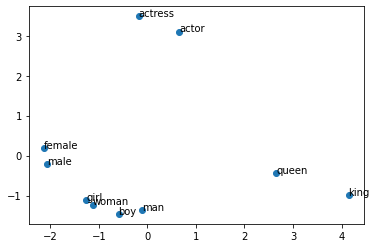

In [22]:

def plot_word_embeddings(words, embedding):
    """Plot the words embedding in 2D using a scatter plot and PCA

    Args:
        words (List[str]): List of words
        embedding: Your word embedding as  gensim keyed vectors object.

    Returns:
        A matplotlib plot object
    """
    # extract word embedding matrix
    X = embedding[words]

    # apply a dimensionality reduction method of your choosing e.g. PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    import pandas as pd
    df = pd.DataFrame(X_pca, index=words, columns=['x', 'y']) # create a dataframe for plotting

    # create a plot object
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    # add point for the words
    ax.scatter(df['x'], df['y'])

    # add word label to each point
    for word, pos in df.iterrows():
            ax.annotate(word, pos)
    
    return ax

words_to_plot = ["man", "woman", "queen", "king", "boy", "girl", "actor", "actress", "male", "female"]
ax = plot_word_embeddings(words=words_to_plot, embedding=word_emb)
ax.plot()


## Plan for class
---

- We will go through the `super().__init__()` to get an initial understanding.
- Work on exercises
- Last 15 minutes: present solutions

<!-- Some exercises
- most similar 
- king - man + woman = queen
- NER

NER (anonymization)

- download a word embedding


- visualizing word embeddings (PCA)


find the most similar word embeddings

plan for class:
    - We will go through the `super().__init__()` to get an initial understanding.
    - Classify named entities -->


### Understanding Super class initialization
We will go through this example at the start of class

In [7]:
class person():
    def __init__(self, name, year_of_birth):
        self.name = name
        self.age = 2021-year_of_birth
    
    def say_hello(self):
        print(f"Hello my name is {self.name} and I am {self.age} years old")

class researcher(person):
    def __init__(self, loc, employment, name, year_of_birth):
        super().__init__(name = name, year_of_birth=year_of_birth) #init refers back to 'def __init__ under person
        self.loc = loc
        self.employment = employment
        
    def say_hello(self):
        print(f"Hello I am currently a {self.employment}, at {self.loc}")
        super().say_hello()

kenneth = researcher("Aarhus", "phd", name = "Kenneth", year_of_birth = 1994)
kenneth.say_hello()
# problem 1:
    # I want to reuse code from the init of person without copy pasting
# problem 2:
    # I want to be able to call the say_hello function of the parent class
    # e.g. kenneth.say_ordinary_hello()

Hello I am currently a phd, at Aarhus
Hello my name is Kenneth and I am 27 years old


What does the pytorch nn.Module init then do? Well from the [source code](https://pytorch.org/docs/stable/_modules/torch/nn/modules/module.html#Module) we find the following:

```py
    def __init__(self):
        """
        Initializes internal Module state, shared by both nn.Module and ScriptModule.
        """
        torch._C._log_api_usage_once("python.nn_module")

        self.training = True
        self._parameters = OrderedDict()
        self._buffers = OrderedDict()
        self._non_persistent_buffers_set = set()
        self._backward_hooks = OrderedDict()
        self._is_full_backward_hook = None
        self._forward_hooks = OrderedDict()
        self._forward_pre_hooks = OrderedDict()
        self._state_dict_hooks = OrderedDict()
        self._load_state_dict_pre_hooks = OrderedDict()
        self._modules = OrderedDict()
```

Which notably sets a couple of internal states (noticably self.training=True), and log it to the pytorch API.

## Exercises
---


you are not required to solve these tasks in any particular order. Exercise 6 is more challenging than the rest so if you are up for a challenge go for it.

1) Skim/read through the Gensim section to get an overview of how to work with word embeddings. 
2) What is to woman what man to doctor (according to the word embedding)? Is this problematic?
3) Discuss how you could use word embeddings to find pluralis of a word
  - apply it to three cases
  - plot these, does there seem to be a *plural component*?
3) Discuss how you would find the antonym of a word
  - apply it to three cases
  - plot these, does there seem to be a *antonym component*?
4) You can also use word embedding to detect the odd one out for instance which word does not belong in *Ross, Kenneth, Tim, glass*? You can do this simply using: `word_emb.doesnt_match("kenneth ross tim glass".split())`. Try this out on three samples.
  - Typically word embeddings are quite intuitive, discuss or write down your best answer to how one might find the odd one out?

<details>
    <summary> Answer </summary>

The function works by:

- taking the mean of all the word-embeddings.
- calculate the similarity (typically using cosine-similarity) from the mean to each word
- return the most dissimilar word (i.e. the one with the highest cosine-distance from that mean vector).

Do note that while your answer might not be the same it might still work as there are multiple ways of doing this. For instance you could also add up the distance between each word and every other word and see which one is the furthest away from all other points.

</details>

5) Which word embedding is closest to the word embedding of *corona*; *virus* or *beer*? Justify your answer before you test it using the word embedding.
  - What does this tell you about word embeddings?
  
6) Word embedding for token classification
  - We will here use token embeddding for classifying part-of-speech tags (i.e. whether a word is a noun or a verb), but this approach could just as well be used to classify whether a word is named entity or whether it is positive or negative. We will here use the English dependency treebank. In the utilities section below I have provided some functions to get you started, but I recommend solving it in 3 steps:
    1) transform the words to word embeddings
    2) Train a classifier to predict the pos-tag using e.g. logistic regression
    3) calculate the performance metrics on the held out test set (how well does it perform on unseen words?)

In [8]:
#1
sim = word_emb.most_similar(positive=["woman", "doctor"], negative=["man"], topn=1)
print(sim)

#This is discriminative! But also reflects the real world, sadly. 

[('nurse', 0.8404642939567566)]


[('girls', 0.8367335200309753)]
[('herd', 0.8191798329353333)]
[('cookies', 0.7720909714698792)]


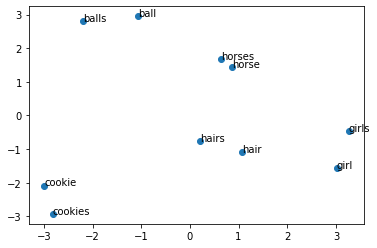

In [25]:
#2
sim = word_emb.most_similar(positive = ["girl", "horses"], negative=["horse"], topn = 1)
print(sim)

sim = word_emb.most_similar(positive=["sheep", "ball"], negative = ["balls"], topn=1)
print(sim)

sim = word_emb.most_similar(positive=["cookie", "hair"], negative=["hairs"], topn = 1)
print(sim)

#plot the embeddings
words_to_plot = ["horse", "horses", "girl", "girls", "ball", "balls", "hair", "hairs", "cookie", "cookies"]

object_to_plot = plot_word_embeddings(words = words_to_plot, embedding = word_emb)
''' there are cluster, but the vectors are not paralel indicating a dimension '''

In [27]:
#3 make antonym
sim = word_emb.most_similar(positive = ["bad", "sweet"], negative = ["good"], topn = 1)
print(sim)

#to investigate do the same analysis as above

[('sour', 0.8003169298171997)]


In [46]:
#4
odd_one = word_emb.doesnt_match("fork cow spoon knife".split())
print(odd_one)

odd_one = word_emb.doesnt_match("carrot tomato cucumber bell".split())
print(odd_one)

#The odd one out is found by the instance the longest from a cluster

cow
bell


In [41]:
#5
closest_associated_beer = word_emb.similarity("corona","beer")
closest_associated_virus = word_emb.similarity("corona", "virus")
print("beer:", closest_associated_beer, "virus:", closest_associated_virus)

#An expression of the corpus the word embeddings is trained on

1.0
beer: 0.1978268 virus: 0.083197795


In [ ]:
#6


## Utilities for tagging POS using word embeddings
This contain a bunch of utility functions for getting started using word embeddings for classifying part of speech tags.

Including a 1) logistic classifier (or a softmax classifier), 2) a function to load in the dataset as a list of token, pos-tag pairs, and 3) a code snippet for turning the label into one hot vectors.  

You can read more about the individual [pos-tags](https://universaldependencies.org/docsv1/en/pos/all.html) here.

In [48]:
import os

from spacy.training import Corpus
import spacy

# change this so it fits your file structure:
path = os.path.join("..", "data", "English Dependency Treeback", "en_ewt-ud-train.spacy")
# and use en_ewt-ud-dev.spacy and en_ewt-ud-test.spacy for the dev and test set.

def load_pos_data(path: str) -> list:
    corpus = Corpus(path)

    nlp = spacy.blank("en")

    def extract_token_label_pair(example):
        e = example.to_dict()
        tokens = e["token_annotation"]["ORTH"]
        entity_labels = e["token_annotation"]["POS"]
        return zip(tokens, entity_labels)
    train_samples = [(token, label) for example in corpus(nlp) for token, label in extract_token_label_pair(example)]

    return train_samples

train = load_pos_data(path)

In [50]:
# exploring the output
print(train[:10])

tokens, labels = list(zip(*train))
print(tokens[:10])

[('Al', 'PROPN'), ('-', 'PUNCT'), ('Zaman', 'PROPN'), (':', 'PUNCT'), ('American', 'ADJ'), ('forces', 'NOUN'), ('killed', 'VERB'), ('Shaikh', 'PROPN'), ('Abdullah', 'PROPN'), ('al', 'PROPN')]


TypeError: 'list' object is not callable

In [11]:
# convert labels to one hot
import pandas as pd
df = pd.get_dummies(labels)
y = df.to_numpy() # One hot representation of the labels
df.head()

,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
import torch
import torch.nn as nn


class Logistic(nn.Module):
    def __init__(self, n_input_features: int, n_output_features: int):
        super().__init__()
        self.linear = nn.Linear(n_input_features, n_output_features)
        self.cost = nn.CrossEntropyLoss()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)
    
    def fit(self, X: torch.Tensor, y: torch.Tensor, epochs = 1000):
        optimizer = torch.optim.AdamW(self.parameters())

        for epoch in range(epochs):
            # forward
            y_hat = self.forward(X)

            # backward
            loss = self.cost(y_hat, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # print
            if (epoch + 1) % 100 == 0:
                print(f"epoch: {epoch+1}, loss = {loss.item():.4f}")



## More on Word embeddings
---


Overview and introduction of word embeddings:

- Andrew NG have a small [video series](https://www.youtube.com/playlist?list=PLhWB2ZsrULv-wEM8JDKA1zk8_2Lc88I-s) on word embedding, which I highly recommend watching

More by Mikolov et al.:

- For the readings for class read on article by Mikolov et al. (2013) however the same year the team released an additional [paper](https://arxiv.org/abs/1310.4546) called *Distributed Representations of Words and Phrases and their Compositionality*. There is even a [video reading](https://www.youtube.com/watch?v=yexR53My2O4) of the paper which takes you through the main points.

Cross-lingual word embeddings:

- Wish I had the time to go through Cross-lingual word embeddings. The idea is that you overlay word embeddings for two languages and then this act as a way of translating between languages. It is a really cool application of word embeddings so if you feel like digging into it I recommend [this podcast episode](https://soundcloud.com/nlp-highlights/57-a-survey-of-cross-lingual-word-embedding-models-with-sebastian-ruder) (in general this podcast is great). You can also watch Kevin Clark (Manning's PhD student) give a [talk](https://www.youtube.com/watch?v=3wWZBGN-iX8&list=PLoROMvodv4rOhcuXMZkNm7j3fVwBBY42z&index=20) on how use word embeddings for translation without any training data.

